### APS 1052 Final Project - VOO Weekly & Monthly Returns by ElasticNet Regression Model

The goal of the project is to use the stock ElasticNet model to predict the future weekly and monthly returns of an ETF. The model is using stock data provided by Yahoo Finance.


In [ ]:
!pip install yfinance
!pip install yahoofinancials

!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(Reading database ... 124042 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import spearmanr
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from pickle import dump
from pickle import load
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

import fAux 
import detrendPrice
import WhiteRealityCheckFor1
import talib as ta

# Data Source
import yfinance as yf
from yahoofinancials import YahooFinancials

In [ ]:
# Download Data from Yahoo Finance

# stocks data
tlsa_data = yf.download('TSLA', start='2002-12-15', end='2022-12-15', progress=False)
ge_data = yf.download('GE', start='2002-12-15', end='2022-12-15', progress=False)
f_data = yf.download('F', start='2002-12-15', end='2022-12-15', progress=False)


# ETFs data
vug_data = yf.download('VUG', start='2002-12-15', end='2022-12-15', progress=False)
spy_data = yf.download('SPY', start='2002-12-15', end='2022-12-15', progress=False)
agg_data = yf.download('AGG', start='2002-12-15', end='2022-12-15', progress=False)

# indices data
gspc_data = yf.download('^GSPC', start='2002-12-15', end='2022-12-15', progress=False)
dji_data = yf.download('^DJI', start='2002-12-15', end='2022-12-15', progress=False)
ixic_data = yf.download('^IXIC', start='2002-12-15', end='2022-12-15', progress=False)

# Predicting ETF
voo_data = yf.download('VOO', start='2012-02-15', end='2022-12-15', progress=False)

In [ ]:
# Download data to local
tlsa_data.to_excel("tlsa_data.xlsx")
ge_data.to_excel("ge_data.xlsx")
f_data.to_excel("f_data.xlsx")
vug_data.to_excel("vug_data.xlsx")
spy_data.to_excel("spy_data.xlsx")
agg_data.to_excel("agg_data.xlsx")
gspc_data.to_excel("gspc_data.xlsx")
dji_data.to_excel("dji_data.xlsx")
ixic_data.to_excel("ixic_data.xlsx")
voo_data.to_excel("voo_data.xlsx")

In [ ]:
# Preprocess data
def clean_data(df): 
    cleaned_df = pd.DataFrame()
    cleaned_df["Date"] = pd.to_datetime(df.iloc[:, 0])
    cleaned_df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(str).astype(float)
    return cleaned_df
 
df_list = [tlsa_data, ge_data, f_data, vug_data, spy_data, agg_data, gspc_data, dji_data, ixic_data, voo_data]

for stock in df_list: 
    df = pd.DataFrame()
    df = clean_data(stock)
    stock = df

## Monthly Return Model

In [ ]:
# Indicators

def calculate_indicator(df, indicator):
    copy_df = df
    return_period = 21
    if 'TRIX' in indicator:
        trix = ta.TRIX(df.Close.values)
        copy_df['Trix'] = trix.tolist()
    if 'DX' in indicator: 
        dx = ta.DX(df.High.values, df.Low.values, df.Close.values, timeperiod = return_period)
        copy_df['Dx'] = dx.tolist()
    if 'SMA' in indicator: 
        sma = ta.SMA(df.Close.values)
        copy_df['Sma'] = sma.tolist()
    if 'CCI' in indicator: 
        cci = ta.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod = return_period)
        copy_df['Cci'] = cci.tolist()
    if 'ROC' in indicator: 
        roc = ta.ROC(df.Close.values, timeperiod = return_period)
        copy_df['Roc'] = roc.tolist()
    if 'CMO' in indicator: 
        cmo = ta.CMO(df.Close.values, timeperiod = return_period)
        copy_df['Cmo'] = cmo.tolist()
    if 'ATR' in indicator: 
        atr = ta.ATR(df.High.values, df.Low.values, df.Close.values, timeperiod = return_period)
        copy_df['Atr'] = atr.tolist()
    return copy_df

In [ ]:
# Define monthly return period
return_period = 21

# Calculate lags from return period 
def calculate_lags(df):
    temp = pd.DataFrame(np.log(df["Adj Close"]).diff(return_period).shift(-return_period))
    return temp

appended_data = []
for stock in df_list:
    temp = calculate_lags(stock)
    appended_data.append(temp)

dataset = pd.DataFrame()
dataset = pd.concat(appended_data, axis=1)
col_names = ["TSLA", "GE", "F", "VUG", "SPY", "AGG", "GSPC", "DJI", "IXIC", "VOO_Predicted"]
dataset.columns = col_names

# calculate lags for VOO
voo_lags = pd.concat([np.log(voo_data["Adj Close"]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*10]], axis=1)
voo_lags.columns = ["VOO_" + str(return_period), "VOO_" + str(return_period*3), "VOO_" + str(return_period*6), "VOO_" + str(return_period*10)]

# Compose complete dataset
complete_data = pd.concat([dataset, voo_lags], axis=1).dropna().iloc[::return_period, :]

# Extract X and Y variables 
CopyX = complete_data[["VOO_Predicted"]].copy()
Y = complete_data[["VOO_Predicted"]].reset_index(drop= True)
X = complete_data.loc[:, complete_data.columns != 'VOO_Predicted']

In [ ]:
voo = calculate_indicator(voo_data, ['TRIX','DX','CMO','ROC','CCI','ATR'])
X = X.join(voo.iloc[:,-6:])
X = X.fillna(X.mean())
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [ ]:
X

,TSLA,GE,F,VUG,SPY,AGG,GSPC,DJI,IXIC,VOO_21,VOO_63,VOO_126,VOO_210,Trix,Dx,Cci,Roc,Cmo,Atr
Date,,,,,,,,,,,,,,,,,,,
2012-12-17,-0.000581,-0.020064,0.221914,0.036020,0.036065,-0.000452,0.034751,0.026883,0.040809,0.059421,-0.017541,0.076724,0.082474,-0.017518,10.242145,103.858411,6.122125,15.040286,1.311239
2013-01-17,0.133241,0.108876,-0.083133,0.025681,0.034858,-0.004243,0.033205,0.031825,0.024441,0.035305,0.034092,0.094708,0.072057,0.037185,24.748683,115.473650,2.854102,25.224797,1.238994
2013-02-19,-0.088586,-0.004137,0.028085,0.018836,0.020234,0.003974,0.017977,0.033355,0.012555,0.034669,0.129395,0.096271,0.114924,0.107589,37.545174,146.643558,3.527674,36.736292,1.054138
2013-03-20,0.285524,-0.075683,-0.032715,-0.008498,-0.001350,0.010384,-0.002222,0.002463,-0.014901,0.020462,0.090436,0.072895,0.181704,0.120068,17.961823,83.485529,2.067290,28.338905,1.174234
2013-04-19,0.631490,0.080361,0.159149,0.074735,0.071058,-0.007580,0.068963,0.052736,0.086700,-0.001015,0.054116,0.088208,0.166146,0.106198,15.212593,-78.590905,-0.572700,3.079638,1.481175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,0.142497,0.056206,0.110400,0.074960,0.053815,0.027010,0.052266,0.045410,0.068277,-0.035596,-0.179128,-0.187765,-0.155023,-0.189012,25.885263,-85.453498,-3.497008,-21.227919,9.035205
2022-07-22,0.062886,0.092252,0.172287,0.048862,0.045181,-0.015743,0.043555,0.035850,0.045223,0.054188,-0.098887,-0.115466,-0.082089,-0.183844,1.414520,143.559942,5.137482,3.580161,7.584105
2022-08-22,0.036864,-0.136784,-0.144581,-0.101200,-0.086916,-0.027960,-0.087863,-0.091129,-0.098494,0.044922,0.063514,-0.042223,-0.079538,0.029844,8.418863,0.180444,4.594632,6.544331,6.268675


In [ ]:
from sklearn.linear_model import ElasticNet

std_slc = StandardScaler()
pca = PCA()
elasticnet = ElasticNet()

pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('elasticnet', elasticnet)])


n_components = list(range(1,X.shape[1]+1,1))
normalize = [True, False]
selection = ['cyclic', 'random']
l1_ratios = [0.1, 0.2, 0.5]
parameters = dict(pca__n_components=n_components,
                      elasticnet__normalize=normalize,
                      elasticnet__selection=selection)

In [ ]:
parameters

{'pca__n_components': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19],
 'elasticnet__normalize': [True, False],
 'elasticnet__selection': ['cyclic', 'random']}

In [ ]:
clf_EN = GridSearchCV(pipe, parameters)
clf_EN.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__normalize': [True, False],
                         'elasticnet__selection': ['cyclic', 'random'],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19]})

In [ ]:
print('Best Number Of Components:', clf_EN.best_estimator_.get_params()['pca__n_components'])
print(clf_EN.best_estimator_.get_params()['elasticnet'])

Best Number Of Components: 1
ElasticNet(normalize=True)


In [ ]:
parametersGrid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}

In [ ]:
grid = GridSearchCV(elasticnet, parametersGrid, scoring='r2', cv=10)

grid.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-02, tolerance: 1.228e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-02, tolerance: 1.268e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]},
             scoring='r2')

In [ ]:
grid.best_estimator_

ElasticNet(alpha=0.0001, l1_ratio=0.0, max_iter=10)

In [ ]:
clf_EN.best_estimator_

Pipeline(steps=[('std_slc', StandardScaler()), ('pca', PCA(n_components=1)),
                ('elasticnet', ElasticNet(normalize=True))])

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

pca = PCA(n_components=1)
pca.fit(x_train)
X_train = pca.transform(x_train)
X_test = pca.transform(x_test)


best_enet = ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=10, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
best_enet.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increas

ElasticNet(alpha=0.0001, l1_ratio=0.0, max_iter=10, normalize=True)

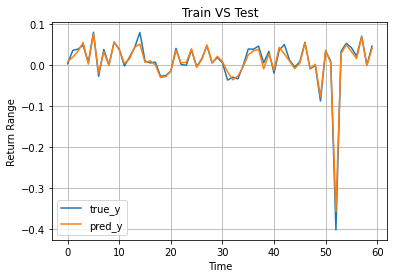

In [ ]:
true_y = y_test.values.ravel()
pred_y = best_enet.predict(x_test)

from matplotlib import pyplot
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.figsize=(10,20)
pyplot.xlabel('Time')
pyplot.ylabel('Return Range')
pyplot.title('Train VS Test')
pyplot.grid()
pyplot.legend()
pyplot.show()

In [ ]:
df_ret = voo_data.iloc[:]['Adj Close'].pct_change(periods=1).fillna(0)
df_ret1 = df_ret.reset_index(drop= True)[:x_train.shape[0],]
df_ret2 = df_ret.reset_index(drop= True)[:x_test.shape[0],]

In [ ]:
positions = np.where(best_enet.predict(x_train)> 0,1,-1 ) 
montly_Ret = pd.Series(positions).shift(1).fillna(0).values * df_ret1
montly_Ret = montly_Ret.fillna(0)
cumret = np.array(np.cumprod(montly_Ret + 1) - 1)

rho, pval = spearmanr(y_test,best_enet.predict(x_test)) 
cagr = (1 + cumret[-1]) ** ((253/21) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((253/21) ** (1.0/2.0)) * np.mean(montly_Ret) / np.std(montly_Ret)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


In-sample: CAGR=0.00606517 Sharpe ratio=0.241381 maxDD=-0.0535273 maxDDD=25 Calmar ratio=0.11331 Rho=0.958933 PVal=1.97601e-33



In [ ]:
positions


array([ 1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,
        1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,
        1, -1,  1,  1,  1,  1,  1, -1])

In [ ]:
positions2 = np.where(best_enet.predict(x_test)> 0,1,-1 )
monthly_ret2 = pd.Series(positions2).shift(1).fillna(0).values * df_ret2
monthly_ret2 = monthly_ret2.fillna(0)
cumret2 = np.array(np.cumprod(monthly_ret2 + 1) - 1)

rho, pval = spearmanr(y_test,best_enet.predict(x_test)) 

cagr = (1 + cumret2[-1]) ** ((253/21) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((253/21) ** (1.0/2.0)) * np.mean(monthly_ret2) / np.std(monthly_ret2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))

Out-of-sample: CAGR=-0.0104927 Sharpe ratio=-0.389251 maxDD=-0.0858513 maxDDD=40 Calmar ratio=-0.12222  Rho=0.958933 PVal=1.97601e-33



average return -0.001469
[-0.00194573  0.00205168]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.9292


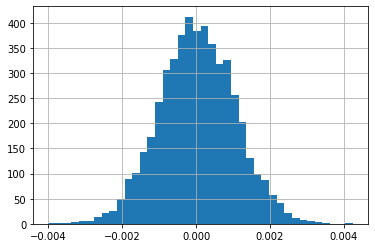

In [ ]:
new_close=voo_data.iloc[:]['Adj Close'].reset_index(drop= True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.pct_change(periods=1).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions2).shift(1).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.show()

In [ ]:
# Train error
train_result = mean_squared_error(best_enet.predict(x_train), y_train)
test_result = mean_squared_error(best_enet.predict(x_test), y_test)

print(train_result, test_result)

2.047889330800641e-05 9.460190723588174e-05


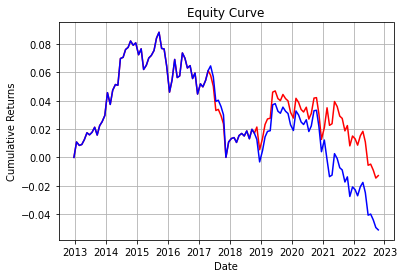

In [ ]:
positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
monthlyRetytrain = pd.Series(positionsytrain).shift(1).fillna(0).values * df_ret1
monthlyRetytrain = monthlyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(monthlyRetytrain + 1) - 1)

positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
monlthlyRetytest = pd.Series(positionsytest).shift(1).fillna(0).values * df_ret2
monlthlyRetytest = monlthlyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(monlthlyRetytest + 1) - 1)

dates = df.loc[CopyX.index.values].index
#dates= dates.reset_index(drop= True)[:x_train.shape[0],]
pyplot.figure(1)
pyplot.plot(dates, np.concatenate((cumretytrain,cumretytest)) ,'r')
pyplot.plot(dates, np.concatenate((cumret,cumret2)),'b')
pyplot.title('Equity Curve')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
pyplot.grid()
pyplot.show()
#dates = df.loc[CopyX.index.values].index # ['Date']
#dates= dates.reset_index(drop= True)[x_train.shape[0]:,]
#pyplot.plot(dates, cumretytest ,'r')
#pyplot.plot(dates, cumret2,'b')

## Weekly Model

In [ ]:
# Indicators

def calculate_indicator(df, indicator):
    copy_df = df
    return_period = 5
    if 'TRIX' in indicator:
        trix = ta.TRIX(df.Close.values)
        copy_df['Trix'] = trix.tolist()
    if 'DX' in indicator: 
        dx = ta.DX(df.High.values, df.Low.values, df.Close.values, timeperiod = return_period)
        copy_df['Dx'] = dx.tolist()
    if 'SMA' in indicator: 
        sma = ta.SMA(df.Close.values)
        copy_df['Sma'] = sma.tolist()
    if 'CCI' in indicator: 
        cci = ta.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod = return_period)
        copy_df['Cci'] = cci.tolist()
    if 'ROC' in indicator: 
        roc = ta.ROC(df.Close.values, timeperiod = return_period)
        copy_df['Roc'] = roc.tolist()
    if 'CMO' in indicator: 
        cmo = ta.CMO(df.Close.values, timeperiod = return_period)
        copy_df['Cmo'] = cmo.tolist()
    if 'ATR' in indicator: 
        atr = ta.ATR(df.High.values, df.Low.values, df.Close.values, timeperiod = return_period)
        copy_df['Atr'] = atr.tolist()
    return copy_df

In [ ]:
# Define monthly return period
return_period = 5

# Calculate lags from return period 
def calculate_lags(df):
    temp = pd.DataFrame(np.log(df["Adj Close"]).diff(return_period).shift(-return_period))
    return temp

appended_data = []
for stock in df_list:
    temp = calculate_lags(stock)
    appended_data.append(temp)

dataset = pd.DataFrame()
dataset = pd.concat(appended_data, axis=1)
col_names = ["TSLA", "GE", "F", "VUG", "SPY", "AGG", "GSPC", "DJI", "IXIC", "VOO_Predicted"]
dataset.columns = col_names

# calculate lags for VOO
voo_lags = pd.concat([np.log(voo_data["Adj Close"]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*10]], axis=1)
voo_lags.columns = ["VOO_" + str(return_period), "VOO_" + str(return_period*3), "VOO_" + str(return_period*6), "VOO_" + str(return_period*10)]

# Compose complete dataset
complete_data = pd.concat([dataset, voo_lags], axis=1).dropna().iloc[::return_period, :]

# Extract X and Y variables 
CopyX = complete_data[["VOO_Predicted"]].copy()
Y = complete_data[["VOO_Predicted"]].reset_index(drop= True)
X = complete_data.loc[:, complete_data.columns != 'VOO_Predicted']

In [ ]:
voo = calculate_indicator(voo_data, ['TRIX','DX','CMO','ROC','CCI','ATR'])
X = X.join(voo.iloc[:,-6:])
X = X.fillna(X.mean())
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [ ]:
from sklearn.linear_model import ElasticNet

std_slc = StandardScaler()
pca = PCA()
elasticnet = ElasticNet()

pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('elasticnet', elasticnet)])


n_components = list(range(1,X.shape[1]+1,1))
normalize = [True, False]
selection = ['cyclic', 'random']
l1_ratios = [0.1, 0.2, 0.5]
parameters = dict(pca__n_components=n_components,
                      elasticnet__normalize=normalize,
                      elasticnet__selection=selection)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

pca = PCA(n_components=1)
pca.fit(x_train)
X_train = pca.transform(x_train)
X_test = pca.transform(x_test)


best_enet = ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=10, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
best_enet.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increas

ElasticNet(alpha=0.0001, l1_ratio=0.0, max_iter=10, normalize=True)

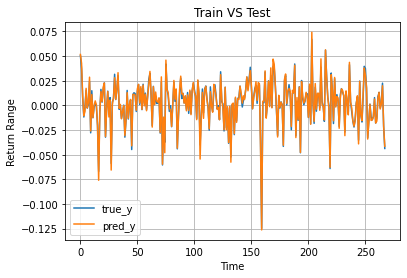

In [ ]:
true_y = y_test.values.ravel()
pred_y = best_enet.predict(x_test)

from matplotlib import pyplot
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.figsize=(10,20)
pyplot.xlabel('Time')
pyplot.ylabel('Return Range')
pyplot.title('Train VS Test')
pyplot.grid()
pyplot.legend()
pyplot.show()

In [ ]:
df_ret = voo_data.iloc[:]['Adj Close'].pct_change(periods=1).fillna(0)
df_ret1 = df_ret.reset_index(drop= True)[:x_train.shape[0],]
df_ret2 = df_ret.reset_index(drop= True)[:x_test.shape[0],]

positions = np.where(best_enet.predict(x_train)> 0,1,-1 ) 
montly_Ret = pd.Series(positions).shift(1).fillna(0).values * df_ret1
montly_Ret = montly_Ret.fillna(0)
cumret = np.array(np.cumprod(montly_Ret + 1) - 1)

rho, pval = spearmanr(y_test,best_enet.predict(x_test)) 
cagr = (1 + cumret[-1]) ** ((253/5) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(montly_Ret) / np.std(montly_Ret)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


In-sample: CAGR=0.0346898 Sharpe ratio=0.625494 maxDD=-0.0638602 maxDDD=69 Calmar ratio=0.543215 Rho=0.992016 PVal=3.12694e-241



In [ ]:
positions2 = np.where(best_enet.predict(x_test)> 0,1,-1 )
monthly_ret2 = pd.Series(positions2).shift(1).fillna(0).values * df_ret2
monthly_ret2 = monthly_ret2.fillna(0)
cumret2 = np.array(np.cumprod(monthly_ret2 + 1) - 1)

rho, pval = spearmanr(y_test,best_enet.predict(x_test)) 

cagr = (1 + cumret2[-1]) ** ((253/5) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(monthly_ret2) / np.std(monthly_ret2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))

Out-of-sample: CAGR=0.00298742 Sharpe ratio=0.0807233 maxDD=-0.161198 maxDDD=182 Calmar ratio=0.0185327  Rho=0.992016 PVal=3.12694e-241



average return 0.000203
[-0.00085463  0.00083714]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.3254


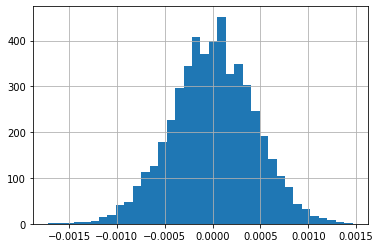

In [ ]:
new_close=voo_data.iloc[:]['Adj Close'].reset_index(drop= True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.pct_change(periods=1).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions2).shift(1).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.show()

In [ ]:
# Train error
train_result = mean_squared_error(best_enet.predict(x_train), y_train)
test_result = mean_squared_error(best_enet.predict(x_test), y_test)

print(train_result, test_result)

7.039159413441891e-06 7.1906130521546984e-06


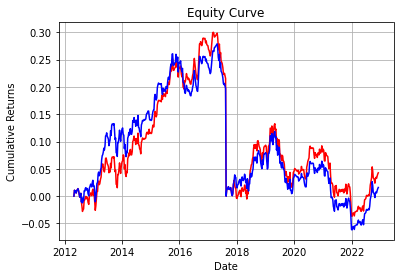

In [ ]:
positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
monthlyRetytrain = pd.Series(positionsytrain).shift(1).fillna(0).values * df_ret1
monthlyRetytrain = monthlyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(monthlyRetytrain + 1) - 1)

positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
monlthlyRetytest = pd.Series(positionsytest).shift(1).fillna(0).values * df_ret2
monlthlyRetytest = monlthlyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(monlthlyRetytest + 1) - 1)

dates = df.loc[CopyX.index.values].index
#dates= dates.reset_index(drop= True)[:x_train.shape[0],]
pyplot.figure(1)
pyplot.plot(dates, np.concatenate((cumretytrain,cumretytest)) ,'r')
pyplot.plot(dates, np.concatenate((cumret,cumret2)),'b')
pyplot.title('Equity Curve')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
pyplot.grid()
pyplot.show()
#dates = df.loc[CopyX.index.values].index # ['Date']
#dates= dates.reset_index(drop= True)[x_train.shape[0]:,]
#pyplot.plot(dates, cumretytest ,'r')
#pyplot.plot(dates, cumret2,'b')